Part0: Import all necessary libraries

In [10]:
import warnings
from sympy import Matrix, zeros, symbols, Function, Symbol, Derivative, diff, simplify, init_printing
from sympy.tensor.array import MutableDenseNDimArray
from IPython.display import display, Latex
from sympy import exp, sin 
from sympy import pprint

warnings.filterwarnings("ignore", category=DeprecationWarning)
init_printing(use_unicode=True)

Part1: Implement functions to compute Christoffel Symbols, Riemann Curvature Tensor, Ricci Curvature Tensor and Scalar Curvature. 

In [11]:
orientationError = 'ERROR: Please enter either "down" or "up" for the orientation of your metric'
indexError = 'ERROR: Please ensure your index values are valid for your metric dimension'

# Function to compute all Christoffel symbols
def ChristoffelSymbols(metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        # Ensure the correct orientation value is provided
        print(orientationError)
    else:
        # Choose the correct metric components based on the index positions
        if orientation == "down":
            gdndn = g
            gupup = gdndn.inv()
        else:
            gupup = g
            gdndn = gupup.inv()

        # Determine the dimension from the number of variables (i.e., n+1 dimensions)
        dim = len(sym)
        # Create a matrix of coordinate variables
        dava = Matrix(sym)
        half = 1/2

        # Create an empty structure for the Christoffel symbols:
        # This is a dim x dim matrix where each element is a list of dim zeros.
        Gamma = Matrix([[[0] * dim for _ in range(dim)] for _ in range(dim)])

        # Compute the Christoffel symbols
        for s in range(dim):
            for m in range(dim):
                for n in range(dim):
                    for l in range(dim):
                        Gamma[(m, n)][l] += simplify(
                            half * gupup[(m, s)] * (
                                diff(gdndn[(s, l)], dava[n]) +
                                diff(gdndn[(n, s)], dava[l]) -
                                diff(gdndn[(n, l)], dava[s])
                            )
                        )
        return Gamma
    

# Function to return a specific Christoffel symbol
def GiveChristoffel(mu, nu, lamb, metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        dim = len(sym)
        if all(isinstance(i, int) and 0 <= i < dim for i in [mu, nu, lamb]):
            chris = ChristoffelSymbols(metricpack)
            return chris[(mu, nu)][lamb]
        else:
            print(indexError)
    

# Function to compute all Riemann tensors
def RiemannTensor(metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        # Get the Christoffel symbols
        Gamma = ChristoffelSymbols(metricpack)
        dim = len(sym)
        dava = Matrix(sym)
        
        # Create an empty structure for the Riemann tensor:
        # This is a dim x dim matrix where each element is a dim x dim list structure.
        Riemann = Matrix([[[[0] * dim for _ in range(dim)] for _ in range(dim)] for _ in range(dim)])

        # First term: compute the difference of partial derivatives of Gamma
        for p in range(dim):
            for s in range(dim):
                for m in range(dim):
                    for n in range(dim):
                        Riemann[(p, s)][m][n] = simplify(
                            diff(Gamma[(p, s)][n], dava[m]) - diff(Gamma[(p, s)][m], dava[n])
                        )
        # Second term: compute the products of Gamma symbols
        for l in range(dim):
            for p in range(dim):
                for s in range(dim):
                    for m in range(dim):
                        for n in range(dim):
                            Riemann[(p, s)][m][n] += simplify(
                                Gamma[(l, s)][n] * Gamma[(p, l)][m] - Gamma[(l, s)][m] * Gamma[(p, l)][n]
                            )

        return Riemann
    

# Function to return a specific component of the Riemann tensor
def GiveRiemann(pho, sigma, mu, nu, metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        dim = len(sym)
        if all(isinstance(i, int) and 0 <= i < dim for i in [pho, sigma, mu, nu]):
            rem = RiemannTensor(metricpack)
            return rem[(pho, sigma)][mu][nu]
        else:
            print(indexError)
    

# Function to compute the Ricci tensor
def RicciTensor(metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        remm = RiemannTensor(metricpack)
        dim = len(sym)
        # Create a dim x dim zero matrix for the Ricci tensor components.
        Ricci = Matrix([[0] * dim for _ in range(dim)])
        
        for x in range(dim):
            for y in range(dim):
                for z in range(dim):
                    Ricci[y, z] += simplify(remm[x, y][z][x])
                    
        return Ricci

    
# Function to return a specific component of the Ricci tensor
def GiveRicci(mu, nu, metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        dim = len(sym)
        if isinstance(mu, int) and isinstance(nu, int) and 0 <= mu < dim and 0 <= nu < dim:
            ricci = RicciTensor(metricpack)
            return simplify(ricci[mu, nu])
        else:
            print(indexError)

    
# Function to compute the Ricci scalar
def RicciScalar(metricpack):
    g, sym, orientation = metricpack

    if orientation not in ("down", "up"):
        print(orientationError)
    else:
        dim = len(sym)
        if orientation == "down":
            gdndn = g
            gupup = gdndn.inv()
        else:
            gupup = g
            
        ricciscalare = 0
        ricciten = RicciTensor(metricpack)
        
        for i in range(dim):
            ricciscalare += gupup[i, i] * ricciten[i, i]
            
        return simplify(ricciscalare)


Part2: Computation

Define variables and metric tensor

In [12]:
# This is an example from Schurz problem 6.35
# Define coordinates and symbolic functions
t, r, h, p = symbols('t r h p', real=True)
Phi = Function('Phi')(r)      # Phi(r) is an abstract function that depends on r
Lambda = Function('Lambda')(r) # Lambda(r) is an abstract function that depends on r
# If we want to set explicit functions like sin, cos, exp, remenber to import from sympy

variables = [t, r, h, p]

# Define the metric g_{µν} (orientation = "down")
gtensor = Matrix([
    [-exp(2*Phi),          0,               0,                   0],
    [           0, exp(2*Lambda),           0,                   0],
    [           0,          0,          r**2,                   0],
    [           0,          0,               0, r**2 * sin(h)**2 ]
])

orientation = "down"

metric = [gtensor, variables, orientation]


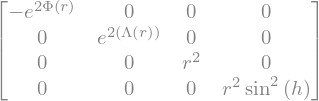

In [13]:
#Display the metric tensor:
gtensor

Compute Christoffel symbols

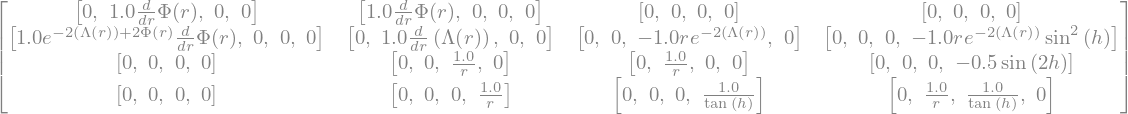

In [14]:
#Display a matrix of all possible Christoffel Symbols:
#The out put is a matrix whose entries are lists(vectors)
ChristoffelSymbols(metric)

#\Gamma^{m}_{nl} corresponds the m-th row and n-th column of the matrix, l corresponds to the l-th elements of the (m,n)-entry.
#We can use the function GiveChristoffel to get that element

Compute Riemann curvature tensor

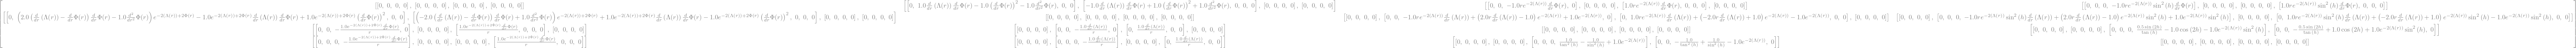

In [15]:
#Display the Riemann Tensor:
RiemannTensor(metric)
#As we can see from the resuly, this might be very long and hard to read
#So I suggest print each entry which is a matrix of the Riemann curvature tensor.

#\R^{p}_{smn} is a matrix, with each entry also being a matrix. p, s denote the rows and columns. m, n denotes the rows and columns of the entry.